In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import util

# Prepare data for analysis

Here we load the translocation data and structural variant data as well as the RNA-seq data or MCF7 cells, and a data set containing replication timing and mean expression data (in MCF7s) for each gene.

In [38]:
# Data available from supplemental info of Nik-Zainal et al (2016)
translocations = pd.read_csv('15_all_fusions.csv')
RNA_seq = pd.read_hdf('RNA_z_score_updated.hdf')
match_data = pd.read_hdf('normalization_data.hdf')
match_data_for_translocations = pd.read_hdf('match_data_translocation_analysis.hdf')
structural_variants =  pd.read_csv('structural_somatic_mutation.BRCA-EU.tsv', sep='\t',
                                   usecols = [4,6,11,12,14,15,16,17,19,23,31,32])

In [39]:
symbol_to_ensembl = {row[1]['gene_name']:row[1]['gene_id'] for row in RNA_seq.iterrows()}
ensembl_to_symbol = {row[1]['gene_id']:row[1]['gene_name'] for row in RNA_seq.iterrows()}

def symbol_lookup(gene):
    try:
        return symbol_to_ensembl[gene]
    except KeyError:
        return 'NA'

def ensembl_lookup(gene):
    try:
        return ensembl_to_symbol[gene]
    except KeyError:
        return 'NA'

def overlaid_histograms(series_1, series_2, series_names, title, bins = np.arange(-7,7,0.5), figsize=(4,2)):
    ax = series_1.hist(alpha=0.5, color='#FF3333', normed=True, bins=bins, figsize=figsize)
    series_2.hist(alpha=0.5, color='#3333FF', normed=True, bins=bins)
    ax.legend(series_names)
    ax.grid(False)
    ax.set_title(title)

# Find genes with rearrangements, and generate matched sets

In [40]:
translocated_gene_names = set(translocations.gene_l) | set(translocations.gene_h)
genes_with_structural_variants = set(structural_variants.gene_affected_by_bkpt_from) & set(structural_variants.gene_affected_by_bkpt_to)

In [41]:
translocated, matched_translocated = util.matched_pairs_multiple(match_data_for_translocations, 
                                                                 translocated_gene_names, 
                                                                 ['rep_timing', 'avg_expression'], 
                                                                 studentize_cols=True)

In [42]:
SV_genes, SV_matched = util.matched_pairs_multiple_factors(match_data, 
                             {ensembl_lookup(g) for g in genes_with_structural_variants}, 
                             ['rep_timing', 'mean_expression'], studentize_cols=True)

# Plot z-scores for translocated genes

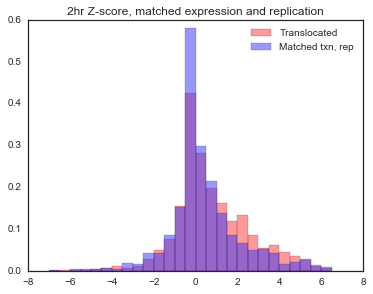

In [43]:
sns.set_style('white')
fig = overlaid_histograms(RNA_seq[RNA_seq.gene_name.isin(translocated.gene_name)].z_21hr,
                    RNA_seq[RNA_seq.gene_name.isin(matched_translocated.gene_name)].z_21hr,
                    ['Translocated', 'Matched txn, rep'],
                    '2hr Z-score, matched expression and replication',
                    figsize=(6,4.5)
                   )

# Plot z-scores for structural variants

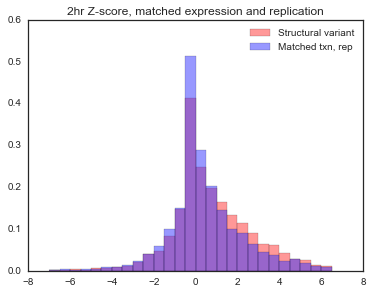

In [45]:
sns.set_style('white')
fig = overlaid_histograms(RNA_seq[RNA_seq.gene_name.isin(SV_genes.gene_name)].z_21hr,
                    RNA_seq[RNA_seq.gene_name.isin(SV_matched.gene_name)].z_21hr,
                    ['Structural variant', 'Matched txn, rep'],
                    '2hr Z-score, matched expression and replication',
                    figsize=(6,4.5)
                   )

# Plot quality of matched set for translocations

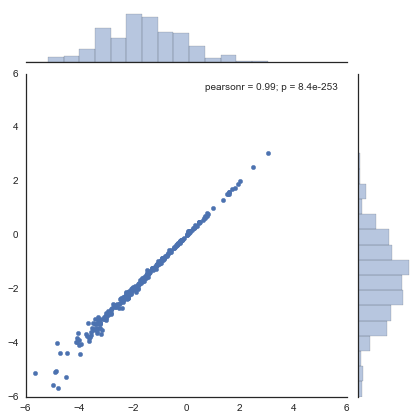

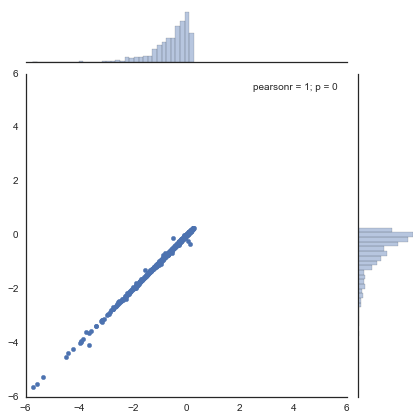

In [46]:
fig = sns.jointplot(np.log(translocated.avg_expression.as_matrix()), 
                    np.log(matched_translocated.avg_expression.as_matrix()),xlim=(-6,6),ylim=(-6,6))
fig = sns.jointplot(np.log(translocated.rep_timing.as_matrix()), 
                    np.log(matched_translocated.rep_timing.as_matrix()),xlim=(-6,6),ylim=(-6,6))

# Plot quality of matched set for structural variants

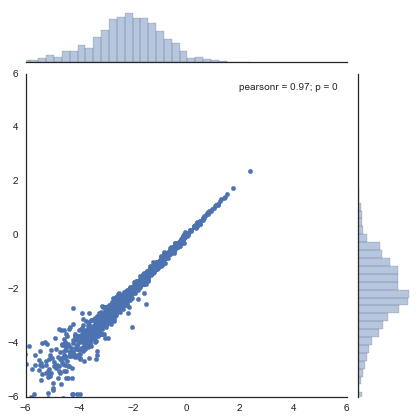

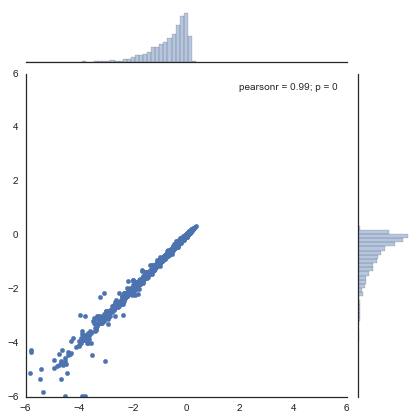

In [47]:
fig = sns.jointplot(np.log(SV_genes.mean_expression.as_matrix()), 
                    np.log(SV_matched.mean_expression.as_matrix()),xlim=(-6,6),ylim=(-6,6))
fig = sns.jointplot(np.log(SV_genes.rep_timing.as_matrix()), 
                    np.log(SV_matched.rep_timing.as_matrix()),xlim=(-6,6),ylim=(-6,6))

# Assess statistical significance

Using a 2-tailed bootstrap of the median, we will assess whether the difference in Z-score medians is signficant between genes with rearrangements, and their matched sets

In [ ]:
sv_medians = util.bootstrap_test_2_samples_median_2_tailed(RNA_seq.z_21hr, 
                                    RNA_seq[RNA_seq.gene_name.isin(SV_genes.gene_name)].z_21hr, 
                                    RNA_seq[RNA_seq.gene_name.isin(SV_matched.gene_name)].z_21hr,
                                    1000000
                                   )

In [ ]:
translocation_medians = util.bootstrap_test_2_samples_median_2_tailed(RNA_seq.z_21hr, 
                                    RNA_seq[RNA_seq.gene_name.isin(translocated.gene_name)].z_21hr, 
                                    RNA_seq[RNA_seq.gene_name.isin(matched_translocated.gene_name)].z_21hr,
                                    1000000
                                   )

In [ ]:
print("Probability of difference in medians for genes with structural variants: p < {}".format(util.pvalue_ceiling(sv_medians)))
print("Probability of difference in medians for genes with translocations: p < {}".format(util.pvalue_ceiling(translocation_medians)))